---
title: 1D Burgers
date: 2023-02-21
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - MEOM Lab
    roles:
      - Primary Programmer
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: PDE, ODE, TimeStepper, Diffrax
---

* Jax-ify
* Don't Reinvent the Wheel

In [1]:
import autoroot
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
import kernex as kex
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Float, Array, PyTree, ArrayLike
import wandb
from jaxsw._src.domain.base import Domain
from jaxsw._src.models.pde import DynamicalSystem
from jaxsw._src.domain.time import TimeDomain

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
jax.config.update("jax_enable_x64", True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

Let's start with a simple 2D Linear Advection scheme. This PDE is defined as:

$$
\begin{aligned}
\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} &= \nu\frac{\partial^2 u}{\partial x^2}
\end{aligned}
$$ (eq:1dburgers)


Here, we are advised to a backwards difference for the advection term, a second order central difference for the diffusion term and a first order time stepper for the time derivative.

## Domain

In [2]:
nx = 101
xmin = 0.0
xmax = 2.0 * jnp.pi

In [3]:
domain = Domain.from_numpoints(xmin=(xmin,), xmax=(xmax,), N=(nx,))

print(f"Size: {domain.size}")
print(f"nDims: {domain.ndim}")
print(f"Grid Size: {domain.grid.shape}")
print(f"Cell Volume: {domain.cell_volume}")

Size: (100,)
nDims: 1
Grid Size: (100, 1)
Cell Volume: 0.06283185307179587


### Initial Conditions

This probably has the most complicated initialization function I've seen in a while. It contains two functions:

$$
\begin{aligned}
u(x,t,\nu) &= - \frac{2\nu}{\phi}\frac{\partial \phi}{\partial x} + 4 \\
\phi(x,t,\nu) &= \exp\left(\frac{-(x-4t)^2}{4\nu(t+1)}\right) + \exp\left(\frac{-(x-4t-2\pi)^2}{4\nu(t+1)}\right)
\end{aligned}
$$

Notice that the $\boldsymbol{u}(x,t,\nu)$ has another function $\phi$ as well as its partial derivative wrt to $x$, $\partial_x\phi$.

In [4]:
import functools as ft


def phi(x, t, nu):
    denominator = 4 * nu * (t + 1)
    t1 = jnp.exp(-((x - 4 * t) ** 2) / denominator)
    t2 = jnp.exp(-((x - 4 * t - 2 * jnp.pi) ** 2) / denominator)
    return t1 + t2

In the original [tutorial](https://nbviewer.org/github/barbagroup/CFDPython/blob/master/lessons/05_Step_4.ipynb), they used [sympy](https://www.sympy.org/en/index.html) to calculate the derivative analytically and then they created a function. I'm a bit lazy, so I will simply use autodifferentiation to calculate the gradient exactly

In [5]:
dphi_dx = jax.grad(phi, argnums=0)

Below, I use a nifty decorator to create a function that auto-vectorizes over the first argument.

In [6]:
@ft.partial(jax.vmap, in_axes=(0, None, None))
def init_u(x, t, nu):
    c = phi(x, t, nu)

    u = -((2 * nu) / c) * dphi_dx(x, t, nu) + 4

    return u

Now we can use this to initialize the Burger's function.

In [7]:
nu = 0.07
t = 0.0

u_init = init_u(domain.coords[0], 0, nu)

assert u_init.shape == domain.coords[0].shape

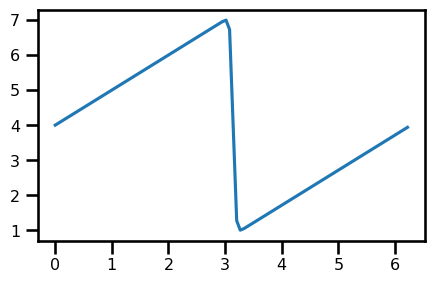

In [8]:
fig, ax = plt.subplots(figsize=(5, 3))

ax.plot(domain.grid.squeeze(), u_init)

plt.show()

### Boundary Conditions

For the boundary conditions, we will use periodic boundary conditions.

$$
\mathcal{BC}[u](x, t) = ..., \hspace{10mm} x\in\partial\Omega \hspace{3mm} t\in\mathcal{T}
$$ (bc)


In [9]:
def bc_fn(u: Float[Array, "D"]) -> Float[Array, "D"]:
    u = u.at[0].set(u[-1])

    return u

In [10]:
u_out = bc_fn(u_init)

### Equation of Motion

Because we are doing advection, we will use backwards difference for each of the terms.

$$
\begin{aligned}
\frac{\partial u}{\partial t} + uD^-[u] &= \nu D^2[u]
\end{aligned}
$$ (eq:1dburgers)

where $D$ is the central finite difference method.

In [11]:
from typing import Optional
from jaxsw._src.operators.functional import advection, diffusion


class Burgers1D(DynamicalSystem):
    @staticmethod
    def equation_of_motion(t: float, u: Array, args):
        u = bc_fn(u)

        nu, domain = args

        rhs_adv = advection.advection_1D(u=u, a=u, step_size=domain.dx[0])

        rhs_diff = diffusion.diffusion_1D(u=u, diffusivity=nu, step_size=domain.dx[0])

        return rhs_diff - rhs_adv

In [12]:
# SPATIAL DISCRETIZATION
u_init = init_u(domain.coords[0], 0, nu)

nu = 0.07

out = Burgers1D.equation_of_motion(0, u_init, (nu, domain))


out.min(), out.max()

(Array(-14.83436605, dtype=float64), Array(173.49642625, dtype=float64))

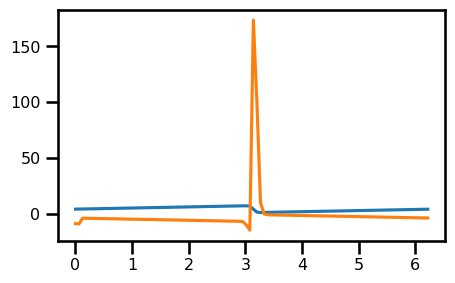

In [13]:
fig, ax = plt.subplots(figsize=(5, 3))

ax.plot(domain.grid.squeeze(), u_init)
ax.plot(domain.grid.squeeze(), out)
plt.show()

## Time Stepping

In [14]:
# TEMPORAL DISCRETIZATION
# initialize temporal domain
tmin = 0.0
tmax = 0.5
num_save = 50

#### CFD Condition

In [15]:
# temporal parameters
c = 1.0
sigma = 0.2
nu = 0.07
dt = domain.dx[0] * nu

In [16]:
# SPATIAL DISCRETIZATION
u_init = init_u(domain.coords[0], 0, nu)


t_domain = TimeDomain(tmin=tmin, tmax=tmax, dt=dt)
ts = jnp.linspace(tmin, tmax, num_save)
saveat = dfx.SaveAt(ts=ts)

# DYNAMICAL SYSTEM
dyn_model = Burgers1D(t_domain=t_domain, saveat=saveat)

In [17]:
u_init = init_u(domain.coords[0], 0, nu)

# Euler, Constant StepSize
solver = dfx.Tsit5()
stepsize_controller = dfx.ConstantStepSize()


sol = dfx.diffeqsolve(
    terms=dfx.ODETerm(dyn_model.equation_of_motion),
    solver=solver,
    t0=ts.min(),
    t1=ts.max(),
    dt0=dt,
    y0=u_init.squeeze(),
    saveat=saveat,
    args=(nu, domain),
    stepsize_controller=stepsize_controller,
)

In [18]:
u_analytical = jax.vmap(init_u, in_axes=(None, 0, None))(domain.coords[0], ts, nu)

## Analysis

In [19]:
da_sol = xr.DataArray(
    data=np.asarray(sol.ys),
    dims=["time", "x"],
    coords={
        "x": (["x"], np.asarray(domain.coords[0])),
        "time": (["time"], np.asarray(sol.ts)),
    },
    attrs={"pde": "linear_convection", "c": c, "sigma": sigma},
)
da_sol

da_analytical = xr.DataArray(
    data=np.asarray(u_analytical),
    dims=["time", "x"],
    coords={
        "x": (["x"], np.asarray(domain.coords[0])),
        "time": (["time"], np.asarray(ts)),
    },
    attrs={"pde": "linear_convection", "c": c, "sigma": sigma},
)

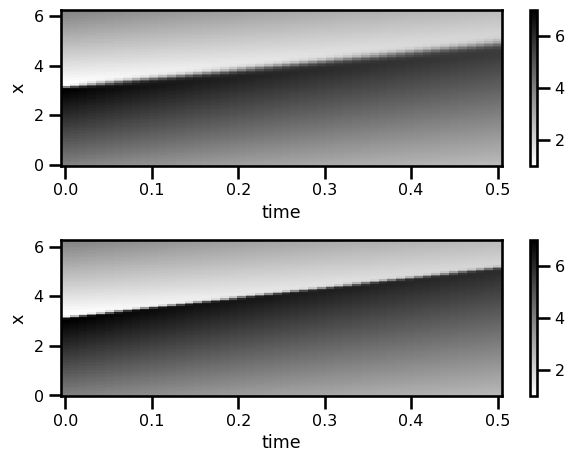

In [20]:
fig, ax = plt.subplots(nrows=2)

da_sol.T.plot.pcolormesh(ax=ax[0], cmap="gray_r")
da_analytical.T.plot.pcolormesh(ax=ax[1], cmap="gray_r")

plt.tight_layout()
plt.show()

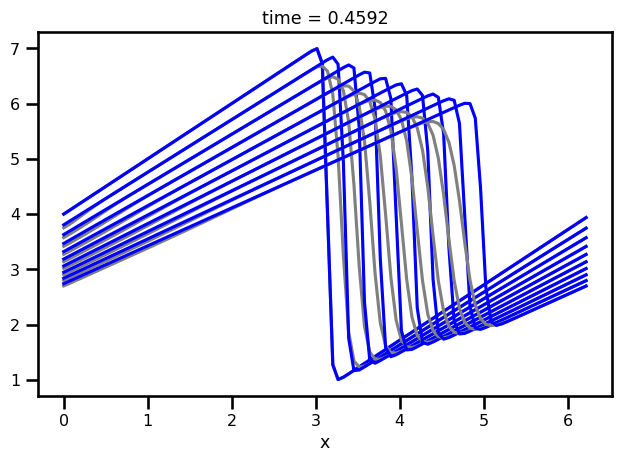

In [21]:
fig, ax = plt.subplots()

for i in range(0, len(da_sol.time), 5):
    da_sol.isel(time=i).plot.line(ax=ax, color="gray")
    da_analytical.isel(time=i).plot.line(ax=ax, color="blue")

plt.tight_layout()
plt.show()